Sampling code to reproduce Fig. 3 of "Feature Learning and Generalization in Deep Networks with Orthogonal Weights" by Day, Kahn, and Roberts. This code runs in about 5 minutes on the T4 high-RAM environment on Google Colab

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import ortho_group
import gc
import pickle

# Generic architecture used to construct the ensemble

In [3]:
class MLP(nn.Module):
    '''
    Simple MLP with the number of layers defined programmatically.
    '''
    def __init__(self, activation, d=784, n=100, L=50, nL=10, cb=0.0, cw=1.0, weightinit='Gaussian'):
        '''
        activation (function) is any activation function
        d (int) is the input dimension (i.e. size of the image)
        n (int) is the width of the hidden layers
        L (int) is the number of hidden layers
        nL (int) is the width of the final layer (i.e. number of classes)
        cb (float) is the variance of the bias parameters
        cw (float) is the variance of the weight parameters

        '''
        super(MLP, self).__init__()

        self.activation = activation
        self.cb = cb
        self.cw = cw
        self.d = d
        self.n = n
        self.L = L
        self.nL = nL
        self.weightinit = weightinit

        assert self.L > 0 # at least 1 hidden layer


        # create layers
        self.fcs = list()

        # first layer is special
        fc0 = nn.Linear(self.d, self.n)
        self.fcs.append(fc0)

        # middle layers, notice the L-1
        for fci in range(L-1):
            fci = nn.Linear(self.n, self.n)
            self.fcs.append(fci)

        # last layer is special
        fcL = nn.Linear(self.n, self.nL)
        self.fcs.append(fcL)

        # register and initialize
        for i, fc in enumerate(self.fcs):
            if self.weightinit == 'mixed0':
                self.weightinit = 'Gaussian' #initializes first layer to Gaussian
                self._initialize_fc(fc)
                self.add_module('fc%d' % i, fc)
                self.weightinit = 'orthogonal' #changes to orthogonal for remaining layers
            else:
                self._initialize_fc(fc)
                self.add_module('fc%d' % i, fc)

    def forward(self, x):
        zs = list()
        a = x
        zs.append(x)
        for i in range(len(self.fcs)-1):
            fc = self.fcs[i]
            z = fc(a)
            zs.append(z)
            a = self.activation(z)
        z = self.fcs[self.L](a) # last one doesn't have activation
        zs.append(z)
        return z, zs

    def _initialize_fc(self, fc):
        '''
        Initializes `fc` layer with cb and cw.
        '''
        with torch.no_grad():
            bs = fc.bias.size()
            b = torch.randn(bs)*(self.cb)**(1/2)
            if self.weightinit == 'orthogonal': #NOTE!!! This only works for rectangular networks for the time being with all layers having equal width
                ws = fc.weight.size()[0]
                w = torch.tensor(np.sqrt(self.cw)*ortho_group.rvs(ws),dtype=torch.float32)
            elif self.weightinit == 'Gaussian':
                ws = fc.weight.size()
                w = torch.randn(ws)*(self.cw/ws[1])**(1/2)
            else:
                raise Exception("Unsupported choice of inits")
            fc.bias = torch.nn.Parameter(b)
            fc.weight = torch.nn.Parameter(w)

def dact(act,x):
    if act == 'ReLU':
        return torch.heaviside(x,values=torch.tensor([0.]))
    elif act == 'tanh':
        return torch.tensor(np.cosh(x.detach().numpy())**-2)
    elif act == 'linear':
        return torch.ones(x.shape)
    else:
        raise Exception("Unsupported choice of activation")

def ddact(act,x):
    if act == 'ReLU':
        return torch.zeros(x.shape) #strictly speaking there is a delta function at zero, but all second derivative correlators end up vanishing for ReLU
    elif act == 'tanh':
        return torch.tensor(-2*(np.cosh(x.detach().numpy())**-2)*np.tanh(x.detach().numpy()))
    elif act == 'linear':
        return torch.zeros(x.shape)
    else:
        raise Exception("Unsupported choice of activation")

def d3act(act,x): #only works for smooth activation functions
    if act == 'tanh':
        return torch.tensor(-2*(np.cosh(x.detach().numpy())**-4) + 4*(np.cosh(x.detach().numpy())**-2)*(np.tanh(x.detach().numpy())**2))
    elif act == 'linear':
        return torch.zeros(x.shape)
    else:
        raise Exception("Unsupported choice of activation")

# Functions to measure various correlators

note that R/S/T/U are measured online since they only involve ddNTK mean

for multi-input, right now only looking at two-input alpha-alpha-beta-beta structure and single-input NTK

layers are 1-indexed: zeroth layer is just a placeholder

In [4]:
def MeasureK(zs,zs2=None):
    zsnp=zs.detach().numpy()
    nl = zs.shape[2]
    if zs2 is None:
        Kmeas = np.mean(np.mean(zsnp**2,axis=2),axis=0)
    else:
        zs2np=zs2.detach().numpy()
        Kmeas = np.mean((1/nl)*np.einsum('ijk,ijk->ij',zsnp,zs2np),axis=0)
    Kmeas[0] = 0 #zeroth layer stuff is just placeholder for everything else
    return Kmeas

def MeasureV(zs,zs2=None):
    zsnp=zs.detach().numpy()
    nl = zs.shape[2]
    if zs2 is None:
        K = MeasureK(zs)
        Vmeas = nl/(nl*(nl-1)/2)*sum(np.mean((zsnp[:,:,i[0]]**2)*(zsnp[:,:,i[1]]**2),axis=0) - K**2 for i in combinations(range(nl),2))
    else:
        zs2np=zs2.detach().numpy()
        K1 = MeasureK(zs)
        K2 = MeasureK(zs2)
        Vmeas = nl/(nl*(nl-1)/2)*sum(np.mean((zsnp[:,:,i[0]]**2)*(zs2np[:,:,i[1]]**2),axis=0) - K1*K2 for i in combinations(range(nl),2))
    Vmeas[0] = 0 #zeroth layer stuff is just placeholder for everything else
    return Vmeas

def MeasureTheta(Hhats):
    nl = Hhats.shape[2]
    return (1/nl)*np.mean(np.trace(Hhats.detach().numpy(),axis1=2,axis2=3),axis=0)

def MeasureA(Hhats,Hhats2=None):
    DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
    nl = Hhats.shape[2]
    if Hhats2 is None:
        Ameas = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[0]]*DeltaHhats[:,:,i[1],i[1]],axis=0) for i in combinations(range(nl),2))
    else:
        DeltaHhats2= Hhats2.detach().numpy() - np.mean(Hhats2.detach().numpy(), axis=0)
        Ameas = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[0]]*DeltaHhats2[:,:,i[1],i[1]],axis=0) for i in combinations(range(nl),2))
    return Ameas

def MeasureB(Hhats, Hhats2=None):
    DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
    nl = Hhats.shape[2]
    if Hhats2 is None:
        Bmeas1 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats[:,:,i[0],i[1]],axis=0) for i in combinations(range(nl),2))
        Bmeas2 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats[:,:,i[1],i[0]],axis=0) for i in combinations(range(nl),2))
        #these should be equal, can return both values to check
    else:
        DeltaHhats2= Hhats2.detach().numpy() - np.mean(Hhats2.detach().numpy(), axis=0)
        Bmeas1 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats2[:,:,i[0],i[1]],axis=0) for i in combinations(range(nl),2))
        Bmeas2 = nl/(nl*(nl-1)/2)*sum(np.mean(DeltaHhats[:,:,i[0],i[1]]*DeltaHhats2[:,:,i[1],i[0]],axis=0) for i in combinations(range(nl),2))
    return Bmeas1

def MeasureD(zs,Hhats):
    DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
    zsnp=zs.detach().numpy()
    nl = Hhats.shape[2]
    Dmeas=nl/(nl*(nl-1)/2)*sum(np.mean((zsnp[:,:,i[0]]**2)*DeltaHhats[:,:,i[1],i[1]],axis=0) for i in combinations(range(nl),2))
    return Dmeas

def MeasureF(zs,Hhats):
    DeltaHhats= Hhats.detach().numpy() - np.mean(Hhats.detach().numpy(), axis=0)
    zsnp=zs.detach().numpy()
    nl = Hhats.shape[2]
    F1meas=nl/(nl*(nl-1)/2)*sum(np.mean(zsnp[:,:,i[0]]*zsnp[:,:,i[1]]*DeltaHhats[:,:,i[0],i[1]],axis=0) for i in combinations(range(nl),2))
    F2meas=nl/(nl*(nl-1)/2)*sum(np.mean(zsnp[:,:,i[0]]*zsnp[:,:,i[1]]*DeltaHhats[:,:,i[1],i[0]],axis=0) for i in combinations(range(nl),2))
    #these should be equal, can return both values to check
    return F1meas

def MeasureP(zs,dHhats):
    zsnp=zs.detach().numpy()
    nl = zsnp.shape[2]
    dHhatsnp = dHhats.detach().numpy()
    Pmeas = nl/(nl*(nl-1)/2)*sum(np.mean(dHhatsnp[:,:,i[0],i[1],i[1]]*zsnp[:,:,i[0]],axis=0) for i in combinations(range(nl),2))
    return Pmeas

def MeasureQ(zs,dHhats):
    zsnp=zs.detach().numpy()
    nl = zsnp.shape[2]
    dHhatsnp = dHhats.detach().numpy()
    Q1meas = nl/(nl*(nl-1)/2)*sum(np.mean(dHhatsnp[:,:,i[0],i[0],i[1]]*zsnp[:,:,i[1]],axis=0) for i in combinations(range(nl),2))
    Q2meas = nl/(nl*(nl-1)/2)*sum(np.mean(dHhatsnp[:,:,i[0],i[1],i[0]]*zsnp[:,:,i[1]],axis=0) for i in combinations(range(nl),2))
    #these should be equal, can return both values to check
    return Q1meas

# Function to collect the tensors and correlators required to perform the measurement

In [5]:
def CollectAllCorrelators(data,data2=None,NSample=1000,depth=10,width=30,inputwidth=30,init='Gaussian',actkey='tanh',
                          lambdabtilde=1.0,lambdaWtilde=1.0,measurePQ=False,measureRSTU=False):

    #set critical initialization
    Cb = 0 #all activations have Cb = 0 for criticality
    if actkey == 'tanh':
        CW = 1.0 # critical init
        act = torch.tanh
    elif actkey == 'linear':
        CW = 1.0 # critical init
        act = lambda x: x
    elif actkey == 'ReLU':
        CW = 2.0 # critical init
        act = nn.ReLU()
    else:
        raise Exception("Unsupported choice of activation")

    #define depth-dependent learning rates for proper definition of NTK
    if actkey == 'tanh':  #bias learning rate is an array that takes into account depth rescaling as appropriate
        lambdab_arr = lambdabtilde*np.array([1/max(l,1) for l in range(0,depth)])
    else:
        lambdab_arr = lambdabtilde*np.ones(depth)

    #initialize all arrays for measurement
    zs=torch.zeros((NSample,depth, width)) #NOTE! zeroth entry is a DUMMY ENTRY ONLY because input width might be different
    Hhats=torch.zeros((NSample,depth,width,width)) #NOTE! zeroth entry is a DUMMY ENTRY ONLY because input width might be different
    if data2 is not None:
        zs2 = torch.zeros((NSample,depth, width))
        Hhats2= torch.zeros((NSample,depth,width,width))
    if measurePQ:
        dHhats = torch.zeros((NSample,depth,width,width,width)) #this is the limiting factor for memory!
    if measureRSTU:
        Rmeas = np.zeros(depth)
        Smeas = np.zeros(depth)
        Tmeas = np.zeros(depth)
        Umeas = np.zeros(depth)

    #auxiliary stuff we don't need to store to preserve RAM
    sigmas=torch.zeros((depth,width))
    sigmaprs=torch.zeros((depth,width))
    if data2 is not None:
        sigmas2 = torch.zeros((depth,width))
        sigmaprs2 = torch.zeros((depth,width))
    sigmapprs=torch.zeros((depth,width))
    sigma3prs=torch.zeros((depth,width))

    #loop over networks in ensemble
    for sample in range(NSample):
        if sample % 5 ==0: print('Sample ',sample,' of ',NSample)
        mynet=MLP(activation=act,d=data.shape[0],n=width,nL=width,L=depth,cw=CW,weightinit=init)

        #initialize dictionary to call network layers
        layerdict_ = {}
        for i, fc in enumerate(mynet.fcs):
            layerdict_['layer%s' % i]  = fc #NOTE INDEXING! layer fcl contains W^(l+1)
            _, zlist = mynet.forward(data)
        if data2 is not None:
            _, zlist2 = mynet.forward(data2)

        #get preactivations and activations/derivatives
        for l in range(1,depth): #leave everything equal to zero at layer zero
            zs[sample,l] = zlist[l]
            sigmas[l] = act(zs[sample,l])
            sigmaprs[l] = dact(actkey,zs[sample,l])
            if data2 is not None:
                zs2[sample,l] = zlist2[l]
                sigmas2[l] = act(zs2[sample,l])
                sigmaprs2[l] = dact(actkey,zs2[sample,l])
            if measurePQ:
                sigmapprs[l] = ddact(actkey,zs[sample,l])
            if measureRSTU:
                sigma3prs[l] = d3act(actkey,zs[sample,l])

        #initial conditions for H recursion at layer 1 (8.23)
        Hhats[sample,1] = torch.eye(width)*(lambdab_arr[1] + (lambdaWtilde/inputwidth)*torch.sum(data**2)) #note that normalization is by inputwidth
        if data2 is not None:
            Hhats2[sample,1] = torch.eye(width)*(lambdab_arr[1] + (lambdaWtilde/inputwidth)*torch.sum(data2**2))
        #note: initial conditions for dH, ddH at layer 1 are automatically satisfied by initialization of dHhat and ddH_I, ddH_II arrays

        if measureRSTU:
            ddH_I = torch.zeros(width,width,width,width) #can compute ddNTK means on the fly so don't need NSample dimension
            ddH_II = torch.zeros(width,width,width,width)

        #compute H forward equation (8.12) and dH forward equation (11.24)
        for l in range(1,depth-1):
            Ws = layerdict_['layer%s' % l].weight
            Hhats[sample,l+1] = torch.eye(width)*(lambdab_arr[l+1] + (lambdaWtilde/width)*torch.sum(sigmas[l]**2)) + torch.einsum('aj,bk,j,k,jk->ab',Ws,Ws,sigmaprs[l],sigmaprs[l],Hhats[sample,l])
            if data2 is not None:
                Hhats2[sample,l+1] = torch.eye(width)*(lambdab_arr[l+1] + (lambdaWtilde/width)*torch.sum(sigmas2[l]**2)) + torch.einsum('aj,bk,j,k,jk->ab',Ws,Ws,sigmaprs2[l],sigmaprs2[l],Hhats2[sample,l])

            if measurePQ:
            #index labeling for einsum: (i0 i1 i2) = (abc), (k0 k1 k2) = (klm)
                dHhats[sample,l+1] = (lambdaWtilde/width)*(torch.einsum('ab,cm,k,k,m,km->abc',torch.eye(width),Ws,sigmaprs[l],sigmas[l],sigmaprs[l],Hhats[sample,l]) +\
                                    torch.einsum('ac,bl,k,l,k,kl->abc',torch.eye(width),Ws,sigmaprs[l],sigmas[l],sigmaprs[l],Hhats[sample,l])) +\
                                    torch.einsum('ak,bl,cm,k,l,m,klm->abc',Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                                    torch.einsum('ak,bl,cm,k,l,m,kl,km->abc',Ws,Ws,Ws,sigmapprs[l],sigmaprs[l],sigmaprs[l],Hhats[sample,l],Hhats[sample,l])


            if measureRSTU:
            #still inside layer loop
            # width*E[ddH_I] with 2 pairs of indices equal is R
            #index labeling for einsum: (i0 i1 i2 i3) = (abcd), (j0 j1 j2 j3) = (jklm), in first 3 terms use delta to eliminate a

                deltaterm = (lambdaWtilde/width)*(torch.einsum('ab,cl,dm,k,l,m,k,kl,km->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                            torch.einsum('ab,cl,dm,k,l,m,k,klm->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                            torch.einsum('ac,dm,bk,l,m,k,l,lm,lk->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                            torch.einsum('ac,dm,bk,l,m,k,l,lmk->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                            torch.einsum('ad,bk,cl,m,k,l,m,mk,ml->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                            torch.einsum('ad,bk,cl,m,k,l,m,mkl->abcd',torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]))

                ddHterm = torch.einsum('aj,bk,cl,dm,k,l,m,j,jklm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],ddH_I) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jkl,jm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jlm,jk->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jmk,jl->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],dHhats[sample,l],Hhats[sample,l]) +\
                  torch.einsum('aj,bk,cl,dm,k,l,m,j,jk,jl,jm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigma3prs[l],Hhats[sample,l],Hhats[sample,l],Hhats[sample,l])
                ddH_I = deltaterm + ddHterm #this is now ddH_I at layer l+1

                #now compute expectations
                Rmeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[0],i[1],i[1]] for i in combinations(range(width),2)).detach().numpy()
                #Rmeas2[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[1],i[0],i[1]] for i in combinations(range(width),2)).detach().numpy() #only need these to check
                #Rmeas3[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_I[i[0],i[1],i[1],i[0]] for i in combinations(range(width),2)).detach().numpy()  #only need these to check

                #index labeling for einsum: (i1 i2 i3 i4) = (abcd), (j1 j2 j3 j4) = (jklm)
                ddH_II = ((lambdaWtilde/width)**2)*torch.einsum('ac,bd,j,k,j,k,jk->abcd',torch.eye(width),torch.eye(width),sigmaprs[l],sigmaprs[l],sigmas[l],sigmas[l],Hhats[sample,l]) +\
                        (lambdaWtilde/width)*(torch.einsum('ab,jk,cl,dm,j,k,l,m,jl,km->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                        torch.einsum('ac,jl,bk,dm,l,m,j,k,kj,km->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                        torch.einsum('ac,jl,bk,dm,l,m,j,k,kjm->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l]) +\
                        torch.einsum('bd,km,aj,cl,m,l,k,j,jk,jl->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l]) +\
                        torch.einsum('bd,km,aj,cl,m,l,k,j,jkl->abcd',torch.eye(width),torch.eye(width),Ws,Ws,sigmas[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],dHhats[sample,l])) +\
                        torch.einsum('aj,bk,cl,dm,l,m,j,k,jklm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmaprs[l],ddH_II) +\
                        torch.einsum('aj,bk,cl,dm,l,m,j,k,jk,jl,km->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmapprs[l],sigmapprs[l],Hhats[sample,l],Hhats[sample,l],Hhats[sample,l]) +\
                        torch.einsum('aj,bk,cl,dm,l,m,j,k,km,jkl->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],dHhats[sample,l]) +\
                        torch.einsum('aj,bk,cl,dm,l,m,k,j,jl,kjm->abcd',Ws,Ws,Ws,Ws,sigmaprs[l],sigmaprs[l],sigmaprs[l],sigmapprs[l],Hhats[sample,l],dHhats[sample,l])
                #now compute expectations
                Smeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[0],i[1],i[1]] for i in combinations(range(width),2)).detach().numpy()
                Tmeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[1],i[0],i[1]] for i in combinations(range(width),2)).detach().numpy()
                Umeas[l+1] += (1/NSample)*width/(width*(width-1)/2)*sum(ddH_II[i[0],i[1],i[1],i[0]] for i in combinations(range(width),2)).detach().numpy()

        #  garbage collection for high-RAM measurement of R,S,T,U
        if measureRSTU:
            del deltaterm
            del ddHterm
            del ddH_I
            del ddH_II
            gc.collect()

    #### end of layer loop

    if measurePQ:
        if measureRSTU:
            RSTUDict={'R': Rmeas, 'S': Smeas, 'T': Tmeas, 'U': Umeas}
            return zs, Hhats, dHhats, RSTUDict
        else:
            return zs, Hhats, dHhats
    if data2 is not None:
        return zs, zs2, Hhats, Hhats2
    else:
        return zs, Hhats

# Create ensemble and measure (reproducing Fig. 3)

In [6]:
#network architecture
depth = 31
width = 20
inputwidth = width
lambdabtilde = 1.0
lambdaWtilde = 1.0

measurePQ = True
measureRSTU = True

NSample = 100
data = torch.Tensor(np.random.rand(inputwidth)) #random data
print(data)

tensor([0.2560, 0.1813, 0.8431, 0.2161, 0.7821, 0.7047, 0.3811, 0.9152, 0.7354,
        0.6078, 0.5328, 0.9052, 0.0292, 0.2213, 0.3445, 0.0657, 0.6293, 0.5366,
        0.3185, 0.6052])


In [7]:
init = 'Gaussian'
actkey = 'tanh'
zsGaus, HhatsGaus, dHhatsGaus, RSTUGaus = CollectAllCorrelators(data,NSample=NSample,depth=depth,width=width,inputwidth=inputwidth,init=init,actkey=actkey,lambdabtilde=lambdabtilde,
    lambdaWtilde=lambdaWtilde,measurePQ=measurePQ,measureRSTU=measureRSTU)

Sample  0  of  100
Sample  5  of  100
Sample  10  of  100
Sample  15  of  100
Sample  20  of  100
Sample  25  of  100
Sample  30  of  100
Sample  35  of  100
Sample  40  of  100
Sample  45  of  100
Sample  50  of  100
Sample  55  of  100
Sample  60  of  100
Sample  65  of  100
Sample  70  of  100
Sample  75  of  100
Sample  80  of  100
Sample  85  of  100
Sample  90  of  100
Sample  95  of  100


In [8]:
init = 'orthogonal'
actkey = 'tanh'
zsOrth, HhatsOrth, dHhatsOrth, RSTUOrth = CollectAllCorrelators(data,NSample=NSample,depth=depth,width=width,inputwidth=inputwidth,init=init,actkey=actkey,lambdabtilde=lambdabtilde,
    lambdaWtilde=lambdaWtilde,measurePQ=measurePQ,measureRSTU=measureRSTU)

Sample  0  of  100
Sample  5  of  100
Sample  10  of  100
Sample  15  of  100
Sample  20  of  100
Sample  25  of  100
Sample  30  of  100
Sample  35  of  100
Sample  40  of  100
Sample  45  of  100
Sample  50  of  100
Sample  55  of  100
Sample  60  of  100
Sample  65  of  100
Sample  70  of  100
Sample  75  of  100
Sample  80  of  100
Sample  85  of  100
Sample  90  of  100
Sample  95  of  100


In [9]:
CorrDictGaus={}
CorrDictGaus['K'] = MeasureK(zsGaus)
CorrDictGaus['Theta'] = MeasureTheta(HhatsGaus)
CorrDictGaus['A'] = MeasureA(HhatsGaus)
CorrDictGaus['B'] = MeasureB(HhatsGaus)
CorrDictGaus['D'] = MeasureD(zsGaus,HhatsGaus)
CorrDictGaus['F'] = MeasureF(zsGaus,HhatsGaus)
CorrDictGaus['P'] = MeasureP(zsGaus,dHhatsGaus)
CorrDictGaus['Q'] = MeasureQ(zsGaus,dHhatsGaus)
CorrDictGaus['R'] = RSTUGaus['R']
CorrDictGaus['S'] = RSTUGaus['S']
CorrDictGaus['T'] = RSTUGaus['T']
CorrDictGaus['U'] = RSTUGaus['U']

CorrDictOrth={}
CorrDictOrth['K'] = MeasureK(zsOrth)
CorrDictOrth['Theta'] = MeasureTheta(HhatsOrth)
CorrDictOrth['A'] = MeasureA(HhatsOrth)
CorrDictOrth['B'] = MeasureB(HhatsOrth)
CorrDictOrth['D'] = MeasureD(zsOrth,HhatsOrth)
CorrDictOrth['F'] = MeasureF(zsOrth,HhatsOrth)
CorrDictOrth['P'] = MeasureP(zsOrth,dHhatsOrth)
CorrDictOrth['Q'] = MeasureQ(zsOrth,dHhatsOrth)
CorrDictOrth['R'] = RSTUOrth['R']
CorrDictOrth['S'] = RSTUOrth['S']
CorrDictOrth['T'] = RSTUOrth['T']
CorrDictOrth['U'] = RSTUOrth['U']

In [10]:
def PlotAllCorrelators(CorrDict,init,width,legend=True):
    K = CorrDict['K']
    Theta = CorrDict['Theta']
    A = CorrDict['A']
    B = CorrDict['B']
    D = CorrDict['D']
    F = CorrDict['F']
    P = CorrDict['P']
    Q = CorrDict['Q']
    R = CorrDict['R']
    S = CorrDict['S']
    T = CorrDict['T']
    U = CorrDict['U']
    depth = len(K)

    plt.scatter(range(1,depth),A[1:]/(Theta[1:]**2),label=r'$\widetilde{A}$')

    plt.scatter(range(1,depth),B[1:]/(Theta[1:]**2),label=r'$\widetilde{B}$')

    plt.scatter(range(1,depth),D[1:]/(Theta[1:]*K[1:]),label=r'$\widetilde{D}$')

    plt.scatter(range(1,depth),F[1:]/(Theta[1:]*K[1:]),label=r'$\widetilde{F}$')

    plt.scatter(range(1,depth),P[1:]/(Theta[1:]**2),label=r'$\tilde{P}$')

    plt.scatter(range(1,depth),Q[1:]/(Theta[1:]**2),label=r'$\tilde{Q}$')

    plt.scatter(range(1,depth),R[1:]*K[1:]/(Theta[1:]**3),label=r'$\tilde{R}$')

    plt.scatter(range(1,depth),S[1:]*K[1:]/(Theta[1:]**3),label=r'$\tilde{S}$')

    plt.scatter(range(1,depth),T[1:]*K[1:]/(Theta[1:]**3),label=r'$\tilde{T}$')

    plt.scatter(range(1,depth),U[1:]*K[1:]/(Theta[1:]**3),label=r'$\tilde{U}$')

    plt.xlim(0.5,depth-0.5)

    plt.title(init+' weights, '+r'$n$ = ' +str(width))
    plt.xlabel(r'Hidden layer $\ell$')
    plt.ylabel('Normalized correlator')
    if(legend==True):
        plt.legend(bbox_to_anchor=(1.02, 0.975), loc='upper left')

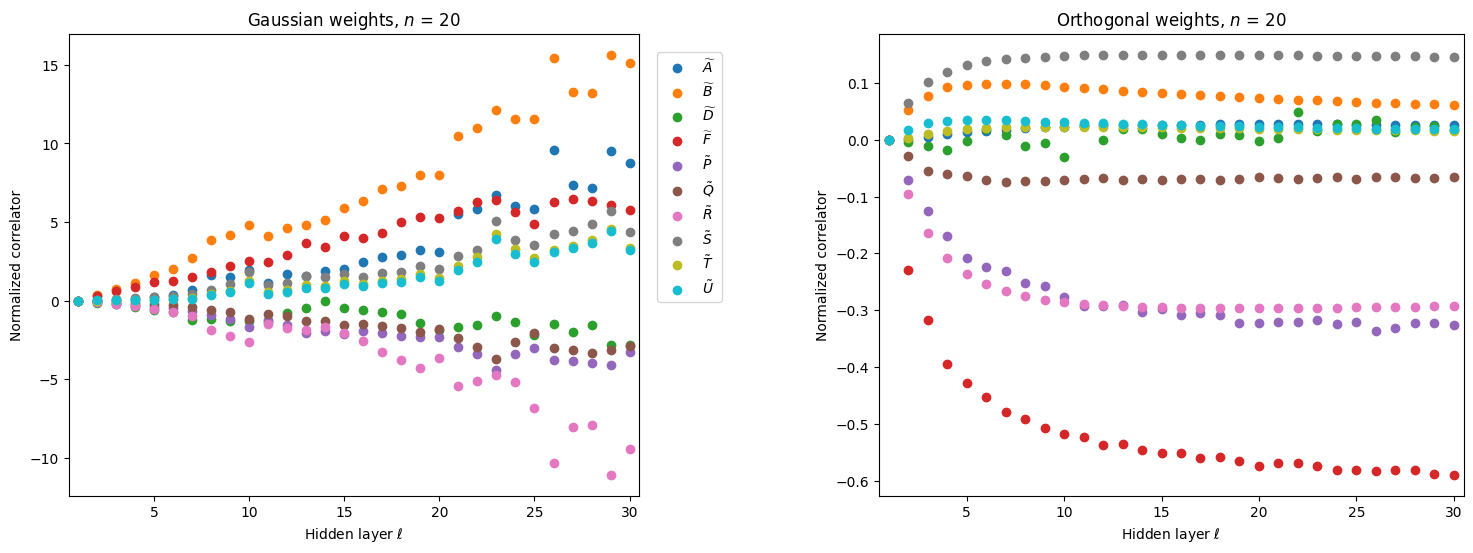

In [11]:
plt.figure(figsize=(18,6))
plt.subplot(1,100,(1,41))
PlotAllCorrelators(CorrDictGaus,'Gaussian',20)
plt.subplot(1,100,(59,100))
PlotAllCorrelators(CorrDictOrth,'Orthogonal',20,legend=False)
plt.show()